# Generative Gaussian Classification Model

The generative gaussian classification model described here takes class prior as p($y = +1$) = p($y = -1$) = 0.5. The class conditional distribution for both classes are considered to be Gaussian $\mathbf{\mathcal{N}(\mu_+,\sigma_+^2 I_2)}$ and $\mathbf{\mathcal{N}(\mu_-,\sigma_-^2 I_2)}$. In model 2, the standard deviation is considered to be same and so the class conditionals are described as $\mathbf{\mathcal{N}(\mu_+,\sigma^2 I_2)}$ and $\mathbf{\mathcal{N}(\mu_-,\sigma^2 I_2)}$. In the third case, we use <b>LinearSVC</b> from sklearn to fit on the given data.

## Data Extraction from File binclass.txt
Run the below cell to extract data from the file <b>binclass.txt</b> mentioned below

In [5]:
#Author: Shrey Bhatt (20111060)

import numpy as np
import math
from sklearn import svm
import matplotlib.pyplot as plt

numDim = 2

#compute the value of u+,u-,sigma+,sigma-
def trainGenGaussian1(x,y):
    
    sum_pv = np.zeros(numDim)
    sum_nv = np.zeros(numDim)
    
    count_pv = 0
    count_nv = 0
    
    for i in range(len(y)):
        if y[i] == 1:
            sum_pv = sum_pv + x[i]
            count_pv+=1
        else:
            sum_nv = sum_nv + x[i]
            count_nv+=1
            
    up = sum_pv/count_pv
    un = sum_nv/count_nv
    
    sigmap = 0
    sigman = 0
    
    for i in range(len(y)):
        if y[i] == 1:
            difv = (x[i] - up)
            diffT = difv.reshape((1,numDim))
            diff = difv.reshape((numDim,1))
            sigmap = sigmap + np.matmul(diffT,diff)[0][0]
        else:
            difv = (x[i] - un)
            diffT = difv.reshape((1,numDim))
            diff = difv.reshape((numDim,1))
            sigman = sigman + np.matmul(diffT,diff)[0][0]           
    
    sigmap = sigmap/(numDim * count_pv)
    sigman = sigman/(numDim * count_nv)
    
    sigmap = math.sqrt(sigmap)
    sigman = math.sqrt(sigman)
    
    return up,un,sigmap,sigman

#function to compute Gaussian probability density for given x,u,sigma
def getGaussianVal(x,u,sigma):
    difn = (x-u)
    diff = difn.reshape((numDim,1))
    diffT = difn.reshape((1,numDim))
    sigmainv = np.linalg.inv(sigma)
    numerMat = np.matmul(np.matmul(diffT,sigmainv),diff)
    numer = numerMat[0][0] * (-1.0)/2.0
    numer = math.exp(numer)
    denom = (2 * math.pi)**numDim * np.linalg.det(sigma)
    denom = math.sqrt(denom)
    probv = numer/denom
    return probv

#predicting the output of given xn using model parameters of gen gaussian 1
def predGenGaussian1(xn,up,un,sigmap,sigman):
    
    sigmapsqI = np.identity(numDim, dtype = float)
    sigmansqI = np.identity(numDim, dtype = float)
    
    sigmapsqI = sigmapsqI*sigmap*sigmap
    sigmansqI = sigmansqI*sigman*sigman
    
    posprob =  getGaussianVal(xn,up,sigmapsqI)
    negprob = getGaussianVal(xn,un,sigmansqI)
    if posprob>=negprob:
        return +1
    else:
        return -1

#predicting the output of given xn using model parameters of gen gaussian 2
def predGenGaussian2(xn,up,un,sigma):
    
    sigmasqI = np.identity(numDim, dtype = float)
    
    sigmasqI = sigmasqI*sigma*sigma
    
    posprob =  getGaussianVal(xn,up,sigmasqI)
    negprob = getGaussianVal(xn,un,sigmasqI)
    if posprob>=negprob:
        return +1
    else:
        return -1

#calculating the confusion matrix of the given model on training data
def valGenGaussian1(x,y,up,un,sigmap,sigman):
    #0 denotes +ve and 1 denotes -ve
    ind = {1:0,-1:1}
    #00 is TP, 01 is FP, 10 is FN, 11 is TN 
    acc = np.zeros((2,2))
    
    for i in range(len(y)):
        xn = x[i]
        yn = y[i]
        yp = predGenGaussian1(xn,up,un,sigmap,sigman)
        acc[ind[yp]][ind[yn]] = acc[ind[yp]][ind[yn]] + 1
    return acc

#calculating the confusion matrix of the given model on training data
def valGenGaussian2(x,y,up,un,sigma):
    #0 denotes +ve and 1 denotes -ve
    ind = {1:0,-1:1}
    #00 is TP, 01 is FP, 10 is FN, 11 is TN 
    acc = np.zeros((2,2))
    for i in range(len(y)):
        xn = x[i]
        yn = y[i]
        yp = predGenGaussian2(xn,up,un,sigma)
        acc[ind[yp]][ind[yn]] = acc[ind[yp]][ind[yn]] + 1
    return acc

#plotting the learning boundary of given model and scatter of given data points
def plotBoundaryGenGaussian(x,y,up,un,sigmap,sigman):
    datax1 = x[:,0]
    datax2 = x[:,1]
    
    x1min = np.amin(datax1)
    x1max = np.amax(datax1)
    
    x2min = np.amin(datax2)
    x2max = np.amax(datax2)
    
    plt.rcParams['figure.dpi'] = 150
    X_pos = x[y==1]
    X_neg = x[y==-1]
    a = 1/((sigmap)**2) - 1/((sigman)**2)
    c = -2 * ((up[0]/sigmap**2) - (un[0]/sigman**2))
    d = -2 * ((up[1]/sigmap**2) - (un[1]/sigman**2))
    e = (up[0]*up[0] + up[1]*up[1])/(sigmap**2) - (un[0]*un[0] + un[1]*un[1])/(sigman**2) + 2*numDim*(math.log(sigmap) - math.log(sigman))
    x1vs = np.linspace(x1min-5, x1max+5, 1000)
    x2vs = np.linspace(x2min-5, x2max+5,1000)
    X1,X2 = np.meshgrid(x1vs, x2vs)
    F = a*X1*X1 + a*X2*X2 + c*X1 + d*X2 + e
    fig,ax = plt.subplots()
    ax.contour(X1, X2, F, levels=[0])
    ax.scatter(x=X_pos[:,0], y=X_pos[:,1], color='red',alpha=0.5)
    ax.scatter(x=X_neg[:,0], y=X_neg[:,1], color='blue',alpha=0.5)
    plt.xlabel("X1")
    plt.ylabel("X2")
    plt.show()

#gen Gaussian 1 fit, predict and plot function
def genGaussian1(x,y):
    up, un, sigmap, sigman = trainGenGaussian1(x,y)
    acc = valGenGaussian1(x,y,up,un,sigmap,sigman)
    print('Trained Parameters for Model 1')
    print('Positive Mean: ', up)
    print('Negative Mean: ', un)
    print('Positive Sigma: ', sigmap)
    print('Negative Sigma: ', sigman)
    print('Confusion Matrix')
    print(int(acc[0][0]), '\t', int(acc[0][1]))
    print(int(acc[1][0]), '\t', int(acc[1][1]))
    print('Accuracy: ', (acc[0][0] + acc[1][1])*100.0/((acc[0][0]+ acc[0][1] + acc[1][0] + acc[1][1])))
    plotBoundaryGenGaussian(x,y,up,un,sigmap,sigman)

#compute the value of u+,u-,sigma
def trainGenGaussian2(x,y):
    sum_pv = np.zeros(numDim)
    sum_nv = np.zeros(numDim)
    
    count_pv = 0
    count_nv = 0
    
    for i in range(len(y)):
        if y[i] == 1:
            sum_pv = sum_pv + x[i]
            count_pv+=1
        else:
            sum_nv = sum_nv + x[i]
            count_nv+=1
            
    up = sum_pv/count_pv
    un = sum_nv/count_nv
    
    sigma = 0
    
    for i in range(len(y)):
        if y[i] == 1:
            difv = (x[i] - up)
            diffT = difv.reshape((1,numDim))
            diff = difv.reshape((numDim,1))
            sigma = sigma + np.matmul(diffT,diff)[0][0]
        else:
            difv = (x[i] - un)
            diffT = difv.reshape((1,numDim))
            diff = difv.reshape((numDim,1))
            sigma = sigma + np.matmul(diffT,diff)[0][0]           
    
    sigma = sigma/(numDim * (count_pv + count_nv))
    
    sigma = math.sqrt(sigma)
    
    return up,un,sigma    
    
#gen Gaussian 2 fit, predict and plot function    
def genGaussian2(x,y):
    up,un,sigma = trainGenGaussian2(x,y)
    acc = valGenGaussian2(x,y,up,un,sigma)
    print('Trained Parameters for Model 2')
    print('Positive Mean: ', up)
    print('Negative Mean: ', un)
    print('Sigma: ', sigma)
    print('Confusion Matrix')
    print(int(acc[0][0]), '\t', int(acc[0][1]))
    print(int(acc[1][0]), '\t', int(acc[1][1]))
    print('Accuracy: ', (acc[0][0] + acc[1][1])*100.0/((acc[0][0]+ acc[0][1] + acc[1][0] + acc[1][1])))
    plotBoundaryGenGaussian(x,y,up,un,sigma,sigma)
    
#extract input and output from files
def extractXY(file_path):
    
    arr_x = []
    arr_y = []
    
    with open(file_path,"r") as fp:
        while True:
            line = fp.readline()
            
            if not line:
                break
                
            temp = []
            
            res = [temp.strip() for temp in line.split(',')]
            for i in range(numDim):
                temp.append(float(res[i]))
            arr_x.append(temp)
            arr_y.append(int(res[numDim]))
            
    x = np.array(arr_x)
    y = np.array(arr_y)
            
    return x,y

#plotting contours for svm
def plot_contours(ax, clf, xx, yy):
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = ax.contour(xx, yy, Z, levels=[0])
    return out

#plotting data and boundary for svm
def plotSVMboundary(svmModel,x,y):
    datax1 = x[:,0]
    datax2 = x[:,1]
    
    x1min = np.amin(datax1)
    x1max = np.amax(datax1)
    
    x2min = np.amin(datax2)
    x2max = np.amax(datax2)
    plt.rcParams['figure.dpi'] = 150
    X_pos = x[y==1]
    X_neg = x[y==-1]
    x1vs = np.linspace(x1min-5, x1max+5, 1000)
    x2vs = np.linspace(x2min-5, x2max+5,1000)
    X1,X2 = np.meshgrid(x1vs, x2vs)
    fig,ax = plt.subplots()
    plot_contours(ax, svmModel, X1, X2)
    ax.scatter(x=X_pos[:,0], y=X_pos[:,1], color='red',alpha=0.5)
    ax.scatter(x=X_neg[:,0], y=X_neg[:,1], color='blue',alpha=0.5)
    plt.xlabel("X1")
    plt.ylabel("X2")
    plt.show()

#linear svm fit, predict and plot function
def svmDetails(x,y):
    svmModel = svm.LinearSVC(C=1.0)
    svmModel.fit(x,y)
    preds = svmModel.predict(x)
    ind = {1:0,-1:1}
    #00 is TP, 01 is FP, 10 is FN, 11 is TN 
    acc = np.zeros((2,2))
    for i in range(len(y)):
        yn = y[i]
        yp = preds[i]
        acc[ind[yp]][ind[yn]] = acc[ind[yp]][ind[yn]] + 1
    
    print('Linear SVM Classifier Details')
    print('Confusion Matrix')
    print(int(acc[0][0]), '\t', int(acc[0][1]))
    print(int(acc[1][0]), '\t', int(acc[1][1]))
    print('Accuracy: ', (acc[0][0] + acc[1][1])*100.0/((acc[0][0]+ acc[0][1] + acc[1][0] + acc[1][1])))
    plotSVMboundary(svmModel,x,y)
    

#Edit below variable value to enter file path
file_path = 'binclass.txt'
x,y = extractXY(file_path)
print('Data Extraction Complete')


Data Extraction Complete


## Generative Gaussian Model 1

Using the MLE method the parameters learned are as follows:

> $\mu_+ = \frac{1}{N_+} \sum_{n: y_n = +1}^{N} x_n$

> $\mu_+ = \frac{1}{N_-} \sum_{n: y_n = -1}^{N} x_n$

> $\sigma_+ = \frac{1}{D  \times  N_+} \sum_{n: y_n = +1}^{N} (x_n - \mu_+)^T (x_n - \mu_+)$

> $\sigma_- = \frac{1}{D  \times  N_+} \sum_{n: y_n = +1}^{N} (x_n - \mu_-)^T (x_n - \mu_-)$

The learned decision boundary indicates the position of points where the probability for class conditionals are same for both class since the class priors are equal.

> $\mathbf{\mathcal{N}(\mu_+,\sigma_+^2 I_2)}  =  \mathbf{\mathcal{N}(\mu_-,\sigma_-^2 I_2)}$

> $(x^T x) (\frac{1}{\sigma_+^2} - \frac{1}{\sigma_-^2}) + (- \frac{2 \mu_+^T}{\sigma_+^2} + \frac{2 \mu_-^T}{\sigma_-^2})x + (2D (log \sigma_+ - log \sigma_-) + \frac{(\mu_+^T \mu_+)}{\sigma_+^2} - \frac{(\mu_-^T \mu_-)}{\sigma_-^2} = 0$

Run the below cell to run the model and plot the data points and learnt decision boundary

Trained Parameters for Model 1
Positive Mean:  [10.01145764 19.5495245 ]
Negative Mean:  [20.32489     9.68799575]
Positive Sigma:  5.158090395760832
Negative Sigma:  3.0823056556654502
Confusion Matrix
186 	 5
14 	 195
Accuracy:  95.25


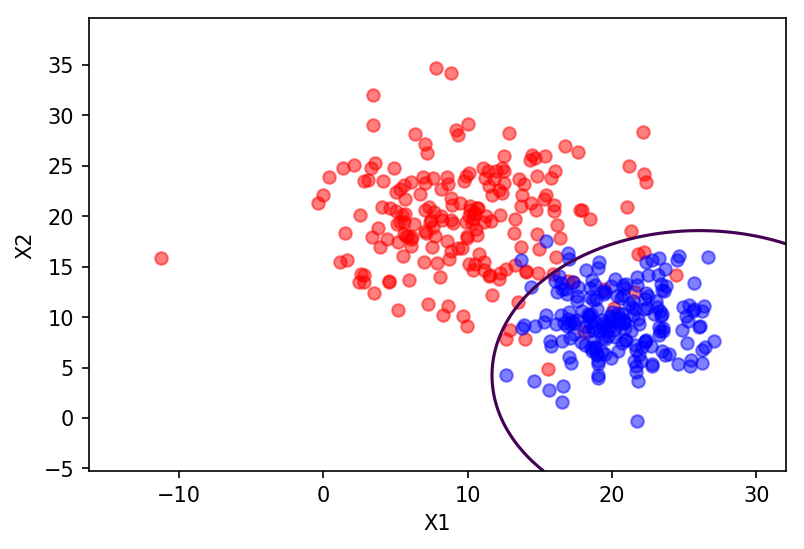

In [6]:
genGaussian1(x,y) #calling gen gaussian 1 on binclass.txt

## Generative Gaussian Model 2

Using the MLE method the parameters learned are as follows:

> $\mu_+ = \frac{1}{N_+} \sum_{n: y_n = +1}^{N} x_n$

> $\mu_+ = \frac{1}{N_-} \sum_{n: y_n = -1}^{N} x_n$

> $\sigma_+ = \frac{1}{D  \times  N} \sum_{n=1}^{N} (x_n - \mu_{+/-})^T (x_n - \mu_{+/-})$

The learned decision boundary indicates the position of points where the probability for class conditionals are same for both class since the class priors are equal.

> $\mathbf{\mathcal{N}(\mu_+,\sigma^2 I_2)}  =  \mathbf{\mathcal{N}(\mu_-,\sigma^2 I_2)}$

>  $ 2*(- \mu_+^T + \mu_-^T)x + (\mu_+^T \mu_+) - (\mu_-^T \mu_-) = 0$

Run the below cell to run the model and plot the data and decision boundary

Trained Parameters for Model 2
Positive Mean:  [10.01145764 19.5495245 ]
Negative Mean:  [20.32489     9.68799575]
Sigma:  4.2489119010511
Confusion Matrix
183 	 2
17 	 198
Accuracy:  95.25


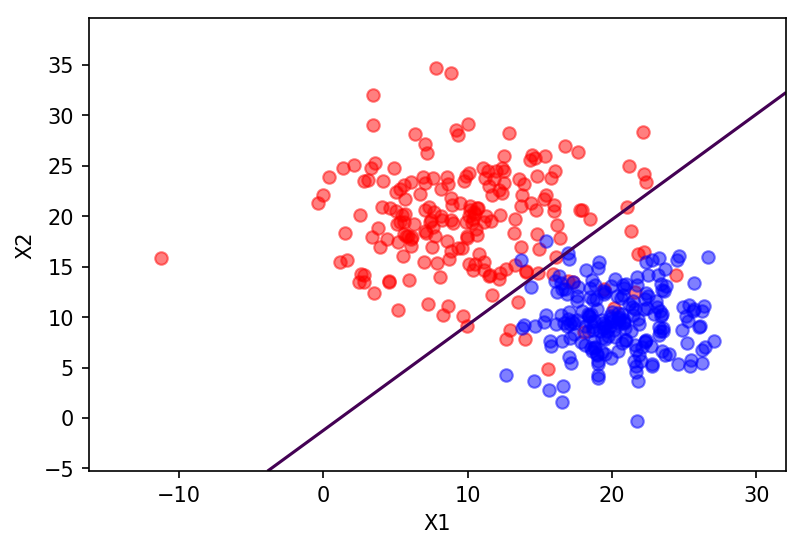

In [7]:
genGaussian2(x,y) #calling gen gaussian 2 on binclass.txt

## Linear SVM Classifier

Run the below cell to check the fit of the same data using Linear SVM classifier implemented by sci-kit learn and also display the learnt decision boundary

Linear SVM Classifier Details
Confusion Matrix
186 	 5
14 	 195
Accuracy:  95.25


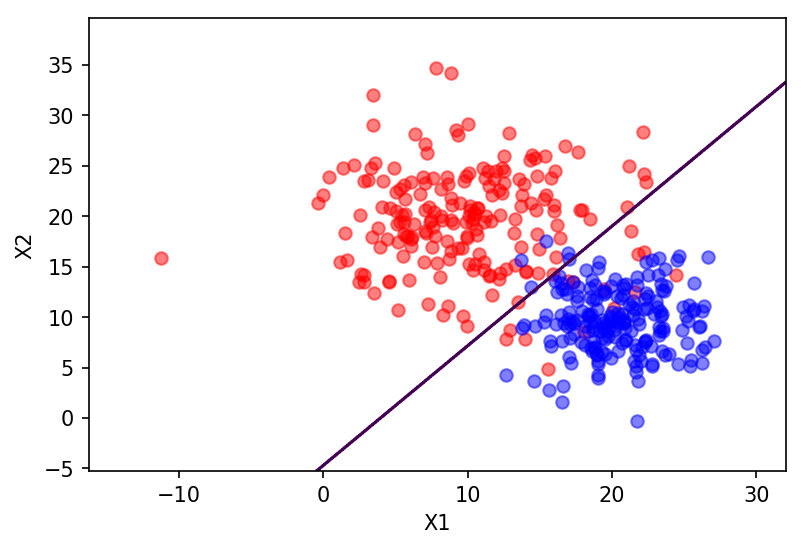

In [8]:
svmDetails(x,y) #calling linear svm 1 on binclass.txt

## binclassv2.txt

Similar to the above cells, the same process is repeated for data in binclassv2.txt

Trained Parameters for Model 1
Positive Mean:  [10.57498364 18.5569005 ]
Negative Mean:  [20.32489     9.68799575]
Positive Sigma:  7.575350738169231
Negative Sigma:  3.0823056556654502
Confusion Matrix
189 	 7
11 	 193
Accuracy:  95.5


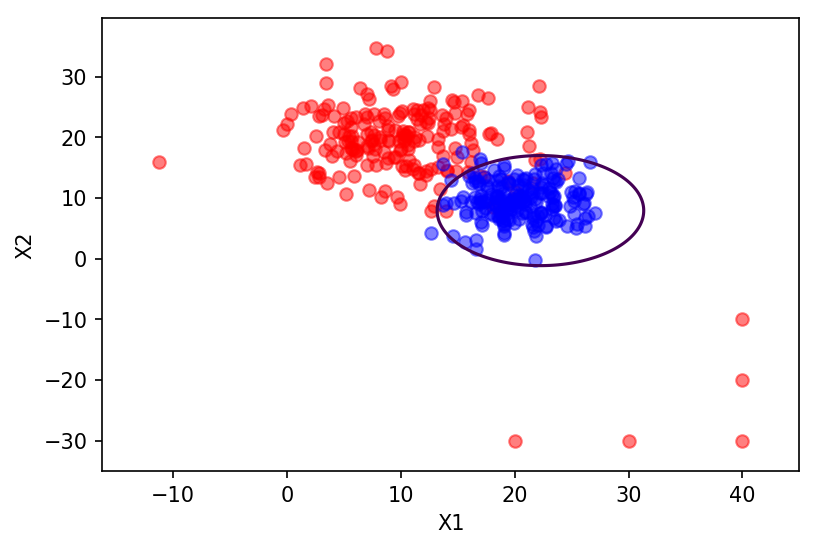

Trained Parameters for Model 2
Positive Mean:  [10.57498364 18.5569005 ]
Negative Mean:  [20.32489     9.68799575]
Sigma:  5.783015950229965
Confusion Matrix
180 	 4
20 	 196
Accuracy:  94.0


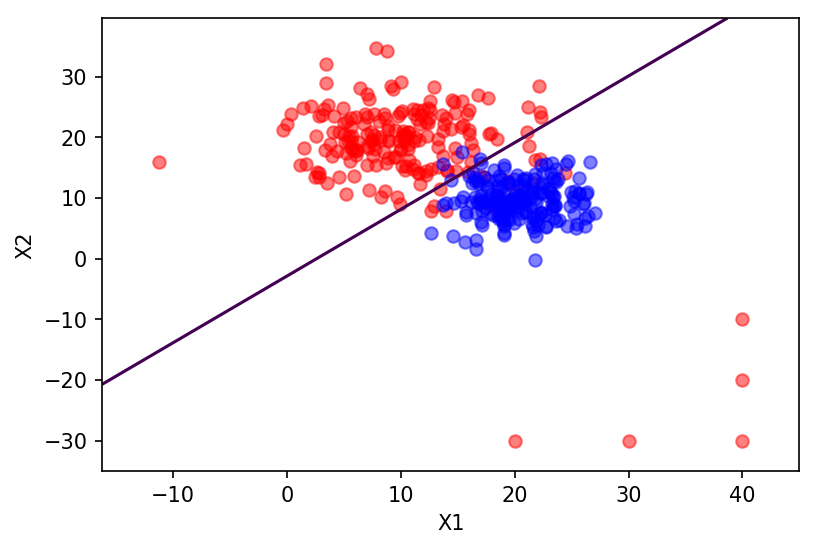

Linear SVM Classifier Details
Confusion Matrix
174 	 3
26 	 197
Accuracy:  92.75


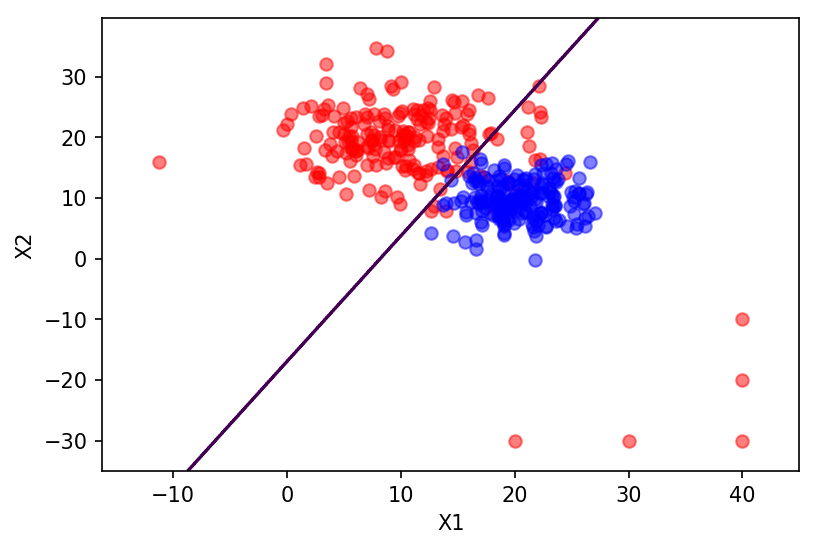

In [9]:
#edit below variable for binclassv2 path
file_path = 'binclassv2.txt'
x2,y2 = extractXY(file_path) #extracting input and output of binclassv2.txt
genGaussian1(x2,y2) #calling gen gaussian 1 on binclassv2.txt
genGaussian2(x2,y2) #calling gen gaussian 2 on binclassv2.txt
svmDetails(x2,y2) #calling linear svm on binclassv2.txt
